<a href="https://colab.research.google.com/github/GawainGan/Machine-Learning-Engineering-for-Production-Specialization/blob/main/3-Machine%20Learning%20Modeling%20Pipelines%20in%20Production/W2/training_comprehensive_guide_Quantization%E6%84%9F%E7%9F%A5%E9%87%8F%E5%8C%96%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 量化感知训练综合指南

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/model_optimization/guide/quantization/training_comprehensive_guide"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 tensorflow.google.cn 上查看</a>
</td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/model_optimization/guide/quantization/training_comprehensive_guide.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/model_optimization/guide/quantization/training_comprehensive_guide.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/model_optimization/guide/quantization/training_comprehensive_guide.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>
</td>
</table>

欢迎阅读 Keras 量化感知训练的综合指南。

本页面记录了各种用例，并展示了如何将 API 用于每种用例​​。了解需要哪些 API 后，可在 [API 文档](https://tensorflow.google.cn/model_optimization/api_docs/python/tfmot/quantization)中找到参数和底层详细信息。

- 如果要查看量化感知训练的好处以及支持的功能，请参阅[概述](https://tensorflow.google.cn/model_optimization/guide/quantization/training.md)。
- 有关单个端到端示例，请参阅[量化感知训练示例](https://tensorflow.google.cn/model_optimization/guide/quantization/training_example.md)。

涵盖了以下用例：

- 按下列步骤操作，部署 8 位量化模型。
    - 定义一个量化感知模型。
    - 仅对于 Keras HDF5 模型，使用特殊的检查点和反序列化逻辑。否则，将使用标准训练。
    - 通过量化感知模型创建量化模型。
- 试验量化。
    - 实验的任何方面都没有支持的部署路径。
    - 自定义 Keras 层处于实验阶段。

## 设置

如果只是查找您需要的 API 并了解其用途，您可以运行但不阅读本部分。

In [ ]:
! pip install -q tensorflow
! pip install -q tensorflow-model-optimization

import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot

import tempfile

input_shape = [20]
x_train = np.random.randn(1, 20).astype(np.float32)
y_train = tf.keras.utils.to_categorical(np.random.randn(1), num_classes=20)

def setup_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(20, input_shape=input_shape),
      tf.keras.layers.Flatten()
  ])
  return model

def setup_pretrained_weights():
  model= setup_model()

  model.compile(
      loss=tf.keras.losses.categorical_crossentropy,
      optimizer='adam',
      metrics=['accuracy']
  )

  model.fit(x_train, y_train)

  _, pretrained_weights = tempfile.mkstemp('.tf')

  model.save_weights(pretrained_weights)

  return pretrained_weights

def setup_pretrained_model():
  model = setup_model()
  pretrained_weights = setup_pretrained_weights()
  model.load_weights(pretrained_weights)
  return model

setup_model()
pretrained_weights = setup_pretrained_weights()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 3.9 MB/s eta 0:00:00
1/1 [==============================] - 18s 18s/step - loss: 2.9753 - accuracy: 0.0000e+00


##定义量化感知模型

通过按以下方式定义模型，可以获得[概述](https://tensorflow.google.cn/model_optimization/guide/quantization/training.md)页面中所列后端的部署路径。默认情况下，使用 8 位量化。

注：量化感知模型实际上并未量化。创建量化模型是一个单独的步骤。

### 量化整个模型

**您的用例：**

- 不支持子类化模型。

**提高模型准确率的提示：**

- 尝试“量化某些层”以跳过量化对准确率影响最大的层。
- 与从头开始训练相比，使用量化感知训练进行微调的效果一般更好。


要使整个模型可以感知量化，请将 `tfmot.quantization.keras.quantize_model` 应用于模型。


In [ ]:
base_model = setup_model()
base_model.load_weights(pretrained_weights) # optional but recommended for model accuracy

quant_aware_model = tfmot.quantization.keras.quantize_model(base_model)
quant_aware_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLa  (None, 20)                3         
 yer)                                                            
                                                                 
 quant_dense_2 (QuantizeWra  (None, 20)                425       
 pperV2)                                                         
                                                                 
 quant_flatten_2 (QuantizeW  (None, 20)                1         
 rapperV2)                                                       
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 420 (1.64 KB)
Non-trainable params: 9 (36.00 Byte)
_________________________________________________________________


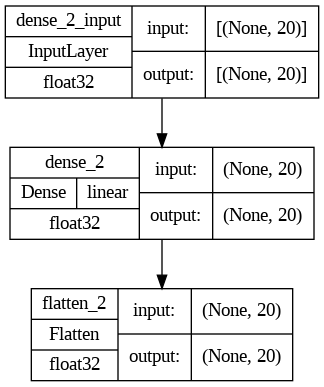

In [ ]:
tf.keras.utils.plot_model(base_model, to_file='base_model.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96, show_dtype=True, show_layer_activations=True)

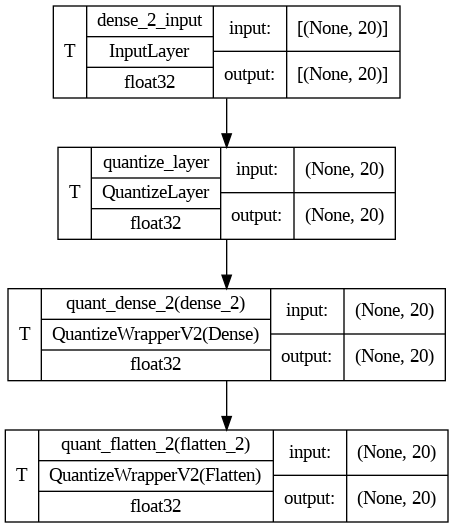

In [ ]:
# prompt: plot the quant_aware_model
tf.keras.utils.plot_model(quant_aware_model, to_file='quant_aware_model.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=96, show_dtype=True, show_layer_activations=True, show_trainable=True)


### 量化某些层

量化模型可能会对准确率造成负面影响。您可以选择性地量化模型的各个层来探索准确率、速度和模型大小之间的最佳平衡。

**您的用例：**

- 要部署到仅适用于完全量化模型（例如 EdgeTPU v1、大多数 DSP）的后端，请尝试“量化整个模型”。

**提高模型准确率的提示：**

- 与从头开始训练相比，使用量化感知训练进行微调的效果一般更好。
- 尝试量化后面的层而不是前面的层。
- 避免量化关键层（例如注意力机制）。


在下面的示例中，仅量化 `Dense` 层。

In [ ]:
# Create a base model
base_model = setup_model()
base_model.load_weights(pretrained_weights) # optional but recommended for model accuracy

# Helper function uses `quantize_annotate_layer` to annotate that only the
# Dense layers should be quantized.
def apply_quantization_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Dense):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer

# Use `tf.keras.models.clone_model` to apply `apply_quantization_to_dense`
# to the layers of the model.
annotated_model = tf.keras.models.clone_model(
    base_model,
    clone_function=apply_quantization_to_dense,
)

# Now that the Dense layers are annotated,
# `quantize_apply` actually makes the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)
quant_aware_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_1 (Quantize  (None, 20)                3         
 Layer)                                                          
                                                                 
 quant_dense_3 (QuantizeWra  (None, 20)                425       
 pperV2)                                                         
                                                                 
 flatten_3 (Flatten)         (None, 20)                0         
                                                                 
Total params: 428 (1.67 KB)
Trainable params: 420 (1.64 KB)
Non-trainable params: 8 (32.00 Byte)
_________________________________________________________________


尽管此示例使用层的类型来决定要量化的内容，但是量化特定层的最简单方式是设置其 `name` 属性，然后在 `clone_function` 中查找该名称。

In [ ]:
print(base_model.layers[0].name)

dense_3


#### 更具可读性，但模型准确率可能较低

这与通过量化感知训练进行的微调不兼容，这就是它的准确率可能低于上述示例的原因。

**函数式模型示例**

In [ ]:
# Use `quantize_annotate_layer` to annotate that the `Dense` layer
# should be quantized.
i = tf.keras.Input(shape=(20,))
x = tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Dense(10))(i)
o = tf.keras.layers.Flatten()(x)
annotated_model = tf.keras.Model(inputs=i, outputs=o)

# Use `quantize_apply` to actually make the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

# For deployment purposes, the tool adds `QuantizeLayer` after `InputLayer` so that the
# quantized model can take in float inputs instead of only uint8.
quant_aware_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 quantize_layer_2 (Quantize  (None, 20)                3         
 Layer)                                                          
                                                                 
 quant_dense_4 (QuantizeWra  (None, 10)                215       
 pperV2)                                                         
                                                                 
 flatten_4 (Flatten)         (None, 10)                0         
                                                                 
Total params: 218 (872.00 Byte)
Trainable params: 210 (840.00 Byte)
Non-trainable params: 8 (32.00 Byte)
_________________________________________________________________


**序贯模型示例**


In [ ]:
# Use `quantize_annotate_layer` to annotate that the `Dense` layer
# should be quantized.
annotated_model = tf.keras.Sequential([
  tfmot.quantization.keras.quantize_annotate_layer(tf.keras.layers.Dense(20, input_shape=input_shape)),
  tf.keras.layers.Flatten()
])

# Use `quantize_apply` to actually make the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

quant_aware_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_3 (Quantize  (None, 20)                3         
 Layer)                                                          
                                                                 
 quant_dense_5 (QuantizeWra  (None, 20)                425       
 pperV2)                                                         
                                                                 
 flatten_5 (Flatten)         (None, 20)                0         
                                                                 
Total params: 428 (1.67 KB)
Trainable params: 420 (1.64 KB)
Non-trainable params: 8 (32.00 Byte)
_________________________________________________________________


## 设置检查点和反序列化

**您的用例**：仅 HDF5 模型格式需要此代码（HDF5 权重或其他格式不需要）。

In [ ]:
# Define the model.
base_model = setup_model()
base_model.load_weights(pretrained_weights) # optional but recommended for model accuracy
quant_aware_model = tfmot.quantization.keras.quantize_model(base_model)

# Save or checkpoint the model.
_, keras_model_file = tempfile.mkstemp('.h5')
quant_aware_model.save(keras_model_file)

# `quantize_scope` is needed for deserializing HDF5 models.
with tfmot.quantization.keras.quantize_scope():
  loaded_model = tf.keras.models.load_model(keras_model_file)

loaded_model.summary()

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_4 (Quantize  (None, 20)                3         
 Layer)                                                          
                                                                 
 quant_dense_6 (QuantizeWra  (None, 20)                425       
 pperV2)                                                         
                                                                 
 quant_flatten_6 (QuantizeW  (None, 20)                1         
 rapperV2)                                                       
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 420 (1.64 KB)
Non-trainable params: 9 (36.00 Byte)
_________________________________________________________________


## 创建并部署量化模型

通常，请参考将要使用的部署后端的文档。

下面是一个 TFLite 后端的示例。

In [ ]:
base_model = setup_pretrained_model()
quant_aware_model = tfmot.quantization.keras.quantize_model(base_model)

# Typically you train the model here.

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_tflite_model = converter.convert()

1/1 [==============================] - 1s 869ms/step - loss: 16.1181 - accuracy: 0.0000e+00


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


## 试验量化

**您的用例**：使用以下 API 意味着没有支持的部署路径。例如，TFLite 转换和内核实现仅支持 8 位量化。这些功能也是实验性功能，不具备向后兼容性。

- `tfmot.quantization.keras.QuantizeConfig`
- `tfmot.quantization.keras.quantizers.Quantizer`
- `tfmot.quantization.keras.quantizers.LastValueQuantizer`
- `tfmot.quantization.keras.quantizers.MovingAverageQuantizer`

### 设置：DefaultDenseQuantizeConfig

要进行实验，需要使用 `tfmot.quantization.keras.QuantizeConfig`，它描述了如何量化层的权重、激活和输出。

以下示例定义了 API 默认值中用于 `Dense` 层的相同 `QuantizeConfig`。

在此示例的正向传播过程中，以 `layer.kernel` 作为输入调用了 `get_weights_and_quantizers` 中返回的 `LastValueQuantizer`，从而产生了输出。通过 `set_quantize_weights` 中定义的逻辑，输出将替换 `Dense` 层的原始正向传播中的 `layer.kernel`。同样的构想也适用于激活和输出。


In [ ]:
LastValueQuantizer = tfmot.quantization.keras.quantizers.LastValueQuantizer
MovingAverageQuantizer = tfmot.quantization.keras.quantizers.MovingAverageQuantizer

class DefaultDenseQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    # Configure how to quantize weights.
    def get_weights_and_quantizers(self, layer):
      return [(layer.kernel, LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False))]

    # Configure how to quantize activations.
    def get_activations_and_quantizers(self, layer):
      return [(layer.activation, MovingAverageQuantizer(num_bits=8, symmetric=False, narrow_range=False, per_axis=False))]

    def set_quantize_weights(self, layer, quantize_weights):
      # Add this line for each item returned in `get_weights_and_quantizers`
      # , in the same order
      layer.kernel = quantize_weights[0]

    def set_quantize_activations(self, layer, quantize_activations):
      # Add this line for each item returned in `get_activations_and_quantizers`
      # , in the same order.
      layer.activation = quantize_activations[0]

    # Configure how to quantize outputs (may be equivalent to activations).
    def get_output_quantizers(self, layer):
      return []

    def get_config(self):
      return {}

### 量化自定义 Keras 层


本示例使用 `DefaultDenseQuantizeConfig` 来量化 `CustomLayer`。

在“试验量化”用例中，应用的配置是相同的。

- 将 `tfmot.quantization.keras.quantize_annotate_layer` 应用于 `CustomLayer` 并在 `QuantizeConfig` 中传递。
- 通过 `tfmot.quantization.keras.quantize_annotate_model` 继续使用 API ​​默认值来量化模型的其余部分。


In [ ]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

class CustomLayer(tf.keras.layers.Dense):
  pass

model = quantize_annotate_model(tf.keras.Sequential([
   quantize_annotate_layer(CustomLayer(20, input_shape=(20,)), DefaultDenseQuantizeConfig()),
   tf.keras.layers.Flatten()
]))

# `quantize_apply` requires mentioning `DefaultDenseQuantizeConfig` with `quantize_scope`
# as well as the custom Keras layer.
with quantize_scope(
  {'DefaultDenseQuantizeConfig': DefaultDenseQuantizeConfig,
   'CustomLayer': CustomLayer}):
  # Use `quantize_apply` to actually make the model quantization aware.
  quant_aware_model = tfmot.quantization.keras.quantize_apply(model)

quant_aware_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_6 (Quantize  (None, 20)                3         
 Layer)                                                          
                                                                 
 quant_custom_layer (Quanti  (None, 20)                425       
 zeWrapperV2)                                                    
                                                                 
 quant_flatten_9 (QuantizeW  (None, 20)                1         
 rapperV2)                                                       
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 420 (1.64 KB)
Non-trainable params: 9 (36.00 Byte)
_________________________________________________________________


### 修改量化参数


**常见误区**：将偏差量化为少于 32 位通常会严重影响模型准确率。

本示例将 `Dense` 层修改为将 4 位用于其权重，而不是默认的 8 位。模型的其余部分继续使用 API 默认值。


In [ ]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

class ModifiedDenseQuantizeConfig(DefaultDenseQuantizeConfig):
    # Configure weights to quantize with 4-bit instead of 8-bits.
    def get_weights_and_quantizers(self, layer):
      return [(layer.kernel, LastValueQuantizer(num_bits=4, symmetric=True, narrow_range=False, per_axis=False))]

在“试验量化”用例中，应用的配置是相同的。

- 将 `tfmot.quantization.keras.quantize_annotate_layer` 应用于 `Dense` 层并在 `QuantizeConfig` 中传递。
- 通过 `tfmot.quantization.keras.quantize_annotate_model` 继续使用 API ​​默认值来量化模型的其余部分。

In [ ]:
model = quantize_annotate_model(tf.keras.Sequential([
   # Pass in modified `QuantizeConfig` to modify this Dense layer.
   quantize_annotate_layer(tf.keras.layers.Dense(20, input_shape=(20,)), ModifiedDenseQuantizeConfig()),
   tf.keras.layers.Flatten()
]))

# `quantize_apply` requires mentioning `ModifiedDenseQuantizeConfig` with `quantize_scope`:
with quantize_scope(
  {'ModifiedDenseQuantizeConfig': ModifiedDenseQuantizeConfig}):
  # Use `quantize_apply` to actually make the model quantization aware.
  quant_aware_model = tfmot.quantization.keras.quantize_apply(model)

quant_aware_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_7 (Quantize  (None, 20)                3         
 Layer)                                                          
                                                                 
 quant_dense_9 (QuantizeWra  (None, 20)                425       
 pperV2)                                                         
                                                                 
 quant_flatten_10 (Quantize  (None, 20)                1         
 WrapperV2)                                                      
                                                                 
Total params: 429 (1.68 KB)
Trainable params: 420 (1.64 KB)
Non-trainable params: 9 (36.00 Byte)
_________________________________________________________________


### 修改要量化的层的部分


本示例将 `Dense` 层修改为跳过量化激活。模型的其余部分继续使用 API 默认值。

In [ ]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

class ModifiedDenseQuantizeConfig(DefaultDenseQuantizeConfig):
    def get_activations_and_quantizers(self, layer):
      # Skip quantizing activations.
      return []

    def set_quantize_activations(self, layer, quantize_activations):
      # Empty since `get_activaations_and_quantizers` returns
      # an empty list.
      return

在“试验量化”用例中，应用的配置是相同的。

- 将 `tfmot.quantization.keras.quantize_annotate_layer` 应用于 `Dense` 层并在 `QuantizeConfig` 中传递。
- 通过 `tfmot.quantization.keras.quantize_annotate_model` 继续使用 API ​​默认值来量化模型的其余部分。

In [ ]:
model = quantize_annotate_model(tf.keras.Sequential([
   # Pass in modified `QuantizeConfig` to modify this Dense layer.
   quantize_annotate_layer(tf.keras.layers.Dense(20, input_shape=(20,)), ModifiedDenseQuantizeConfig()),
   tf.keras.layers.Flatten()
]))

# `quantize_apply` requires mentioning `ModifiedDenseQuantizeConfig` with `quantize_scope`:
with quantize_scope(
  {'ModifiedDenseQuantizeConfig': ModifiedDenseQuantizeConfig}):
  # Use `quantize_apply` to actually make the model quantization aware.
  quant_aware_model = tfmot.quantization.keras.quantize_apply(model)

quant_aware_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_8 (Quantize  (None, 20)                3         
 Layer)                                                          
                                                                 
 quant_dense_10 (QuantizeWr  (None, 20)                423       
 apperV2)                                                        
                                                                 
 quant_flatten_11 (Quantize  (None, 20)                1         
 WrapperV2)                                                      
                                                                 
Total params: 427 (1.67 KB)
Trainable params: 420 (1.64 KB)
Non-trainable params: 7 (28.00 Byte)
_________________________________________________________________


### 使用自定义量化算法


`tfmot.quantization.keras.quantizers.Quantizer` 类是一个可调用对象，可以将任何算法应用于其输入。

在本示例中，输入是权重，我们将 `FixedRangeQuantizer` **call** 函数中的数学运算应用于权重。现在，`FixedRangeQuantizer` 的输出将代替原始权重值传递给使用这些权重的任何对象。

In [ ]:
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
quantize_annotate_model = tfmot.quantization.keras.quantize_annotate_model
quantize_scope = tfmot.quantization.keras.quantize_scope

class FixedRangeQuantizer(tfmot.quantization.keras.quantizers.Quantizer):
  """Quantizer which forces outputs to be between -1 and 1."""

  def build(self, tensor_shape, name, layer):
    # Not needed. No new TensorFlow variables needed.
    return {}

  def __call__(self, inputs, training, weights, **kwargs):
    return tf.keras.backend.clip(inputs, -1.0, 1.0)

  def get_config(self):
    # Not needed. No __init__ parameters to serialize.
    return {}


class ModifiedDenseQuantizeConfig(DefaultDenseQuantizeConfig):
    # Configure weights to quantize with 4-bit instead of 8-bits.
    def get_weights_and_quantizers(self, layer):
      # Use custom algorithm defined in `FixedRangeQuantizer` instead of default Quantizer.
      return [(layer.kernel, FixedRangeQuantizer())]

在“试验量化”用例中，应用的配置是相同的。

- 将 `tfmot.quantization.keras.quantize_annotate_layer` 应用于 `Dense` 层并在 `QuantizeConfig` 中传递。
- 通过 `tfmot.quantization.keras.quantize_annotate_model` 继续使用 API ​​默认值来量化模型的其余部分。

In [ ]:
model = quantize_annotate_model(tf.keras.Sequential([
   # Pass in modified `QuantizeConfig` to modify this `Dense` layer.
   quantize_annotate_layer(tf.keras.layers.Dense(20, input_shape=(20,)), ModifiedDenseQuantizeConfig()),
   tf.keras.layers.Flatten()
]))

# `quantize_apply` requires mentioning `ModifiedDenseQuantizeConfig` with `quantize_scope`:
with quantize_scope(
  {'ModifiedDenseQuantizeConfig': ModifiedDenseQuantizeConfig}):
  # Use `quantize_apply` to actually make the model quantization aware.
  quant_aware_model = tfmot.quantization.keras.quantize_apply(model)

quant_aware_model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer_9 (Quantize  (None, 20)                3         
 Layer)                                                          
                                                                 
 quant_dense_11 (QuantizeWr  (None, 20)                423       
 apperV2)                                                        
                                                                 
 quant_flatten_12 (Quantize  (None, 20)                1         
 WrapperV2)                                                      
                                                                 
Total params: 427 (1.67 KB)
Trainable params: 420 (1.64 KB)
Non-trainable params: 7 (28.00 Byte)
_________________________________________________________________
